In [1]:
import os
import sys
import gin
import numpy as np
import pandas as pd
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from IPython.core.display import clear_output, display

import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2


In [2]:
from prepare import parse

csv_params = {
"sep": '\s+',
"nrows": 15000,
"encoding": 'utf-8',
"names": ['event',  'x', 'y', 'z', 'station', 'track', 'px', 'py', 'pz', 'X0', 'Y0', 'Z0']
}

stations_constraints = {
    0: {'x': [-166.6, 166.6], 'y': [-166.6, 166.6], 'z': [-423.5, 423.5]},
    1: {'x': [-166.6, 166.6], 'y': [-166.6, 166.6], 'z': [-423.5, 423.5]},
    2: {'x': [-166.6, 166.6], 'y': [-166.6, 166.6], 'z': [-423.5, 423.5]},
}

In [3]:
events = parse("/zfs/hybrilit.jinr.ru/user/p/pgonchar/data/bes3/events/3.txt", csv_params=csv_params, events_quantity=':')
events = next(events)[0]
n_events = 312
events_to_analyze = events[events.event < n_events]

In [4]:
events_to_analyze

,event,x,y,z,station,track,px,py,pz,X0,Y0,Z0
0,0,-80.90526,-10.274100,-145.164000,0,-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0,-75.78151,-30.139360,-36.078560,0,-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0,-75.78151,-30.139360,259.800600,0,-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0,70.23064,-41.459310,-249.458300,0,-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0,-124.69720,-18.451980,-211.953700,1,-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
14947,311,118.91890,-41.811080,-238.796800,1,23,0.237803,-0.102587,-0.500582,0.838779,-0.231903,-1.184486
14948,311,158.23000,-51.998400,-317.999400,2,23,0.237803,-0.102587,-0.500582,0.838779,-0.231903,-1.184486
14949,311,81.24136,7.145566,0.349709,0,26,0.318604,0.052094,0.057076,0.838779,-0.231903,-1.184486
14950,311,125.61850,10.481710,8.307509,1,26,0.318604,0.052094,0.057076,0.838779,-0.231903,-1.184486


In [259]:
!ls /zfs/hybrilit.jinr.ru/user/n/nuvard/ariadne/lightning_logs/TrackNETv2

last	    version_12	version_17  version_21	version_5
version_0   version_13	version_18  version_22	version_6
version_1   version_14	version_19  version_23	version_7
version_10  version_15	version_2   version_3	version_8
version_11  version_16	version_20  version_4	version_9


In [5]:
import torch

tracknet_ckpt_path_dict = {'model_dir': '/zfs/hybrilit.jinr.ru/user/n/nuvard/ariadne/lightning_logs/TrackNETv2', 
                           'version': 'version_22', 'checkpoint': 'latest'}
classifier_ckpt_path_dict = {'model_dir': '/zfs/hybrilit.jinr.ru/user/n/nuvard/ariadne/lightning_logs/TrackNetClassifier', 
                             'version': 'version_108', 'checkpoint': 'latest'}
input_dir='/zfs/hybrilit.jinr.ru/user/n/nuvard/ariadne/output/cgem_t_plain_valid_gov_test'
file_mask = 'tracknet_599.npz'
last_station_file_mask='tracknet_599_last_station.npz'
use_classifier=True
draw_figures=True
max_num_events=200
treshold_min=0.35
treshold_max=0.9
treshold_step=0.05
tracknet_input_features=3
tracknet_conv_features=32

_constraints = {'r': [80., 167.], 'phi': [-3.15, 3.15], 'z': [-423.5, 423.5]}
_columns=('r', 'phi', 'z')

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
from ariadne.utils import get_checkpoint_path, weights_update
from ariadne.tracknet_v2.model import TrackNETv2
from ariadne.tracknet_v2_1.model import TrackNetClassifier

In [39]:
path_to_tracknet_ckpt = get_checkpoint_path(**tracknet_ckpt_path_dict)
path_to_classifier_ckpt = get_checkpoint_path(**classifier_ckpt_path_dict)

model = weights_update(model=TrackNETv2(input_features=tracknet_input_features,
                                        conv_features=tracknet_conv_features,
                                        rnn_type='gru',
                                        batch_first=True),
                       checkpoint=torch.load(path_to_tracknet_ckpt, map_location=torch.device(DEVICE)))
model.eval()

TrackNETv2(
  (conv): Sequential(
    (0): Conv1d(3, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (1): ReLU()
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (rnn): GRU(32, 32, num_layers=2, batch_first=True)
  (xy_coords): Sequential(
    (0): Linear(in_features=32, out_features=2, bias=True)
  )
  (r1_r2): Sequential(
    (0): Linear(in_features=32, out_features=2, bias=True)
    (1): Softplus(beta=1, threshold=20)
  )
)

In [40]:
model.to(DEVICE)
class_model = weights_update(model=TrackNetClassifier(coord_size=2),
                             checkpoint=torch.load(path_to_classifier_ckpt, map_location=torch.device(DEVICE)))
class_model.to(DEVICE)

TrackNetClassifier(
  (gru_feat_block): Sequential(
    (0): Linear(in_features=32, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=15, bias=True)
  )
  (coord_feat_block): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=15, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=30, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=1, bias=True)
  )
)

In [41]:
from ariadne.utils import load_data, store_in_index,search_in_index
from ariadne.graph_net.graph_utils.graph_prepare_utils import to_pandas_graph_from_df


from ariadne.transformations import Compose, ConstraintsNormalize, ToCylindrical, DropSpinningTracks, DropShort

In [42]:
events = load_data(input_dir, file_mask, None)
all_last_station_coordinates = load_data(input_dir, last_station_file_mask, None)

[[-0.03212956 -0.12680989 -0.96425285]
 [-0.11586902  0.51660818  0.05873527]]
[-2. -2.]
2
[nan nan nan]
False
0
[0.28954144 0.50203806]
0


In [43]:
import itertools

def get_seeds(hits, columns=['x','y','z']):
    temp1 = hits[hits.station == 0]
    st0_hits = hits[hits.station == 0][columns].values
    temp2 = hits[hits.station == 1]
    st1_hits = hits[hits.station == 1][columns].values
    # all possible combinations
    idx0 = range(len(st0_hits))
    idx1 = range(len(st1_hits))
    idx_comb = itertools.product(idx0, idx1)
    # unpack indices
    idx0, idx1 = zip(*idx_comb)
    idx0 = list(idx0)
    idx1 = list(idx1)
    # create seeds array
    seeds = np.zeros((len(idx0), 2, 3))
    seeds[:, 0, ] = st0_hits[idx0]
    seeds[:, 1, ] = st1_hits[idx1]
    return seeds

In [165]:
NUM_COMPONENTS = 2
SUFX = ['_p', '_c']
COLS = ['z', 'phi']

transformer = Compose([
        DropSpinningTracks(),
        DropShort(num_stations=3),
        ToCylindrical(drop_old=True),
        ConstraintsNormalize(columns=_columns, constraints=_constraints)
    ])

def build_index(target_df):
    cont = np.ascontiguousarray(target_df[COLS].values)
    return store_in_index(cont, num_components=2)

def search(points, index):
    cont = np.ascontiguousarray(points[COLS].values)
    return search_in_index(cont, index, 10)

def to_cart(df):
    graph=to_pandas_graph_from_df(df,SUFX, save_index=False)
    seeds = graph[(graph.station_p == 0) & (graph.station_c == 1)]
    target = df[df.station == 2]
    return seeds, target

def seeds_to_input(seeds_df):
    return seeds_df[['z_p', 'phi_p', 'r_p', 'z_c', 'phi_c', 'r_c']].values.reshape((-1, 2, 3))

def process_one_event(event_df):
    event_df = event_df[['event','x','y','z','station','track']]
    
    try:
        event_df = transformer(event_df)
    except AssertionError as err:
        print("ASS error %r" % err)
        return None
    event_df.rename(columns={'index': 'index_old'}, inplace=True)
    seeds, target = to_cart(event_df)
    
    #index = build_index(target)
    # search(target[:2], index)
    batch = seeds_to_input(seeds)
    chunk_data_len = torch.tensor(np.full(len(batch), 2), dtype=torch.int64).to(DEVICE)

    return seeds, target, model(torch.tensor(batch).to(DEVICE), chunk_data_len, return_gru_states=True), batch
    #return seeds, target


In [164]:
one_event = events_to_analyze[events_to_analyze.event == 0]
seeds, target, pred, batch = process_one_event(one_event)
pred[0][0]

tensor([[ 0.1876, -0.4003,  0.2421,  0.2498],
        [-0.0590, -0.5545,  0.1459,  0.1391]], device='cuda:0',
       grad_fn=<SelectBackward>)

In [162]:
batch.shape

(35, 2, 3)

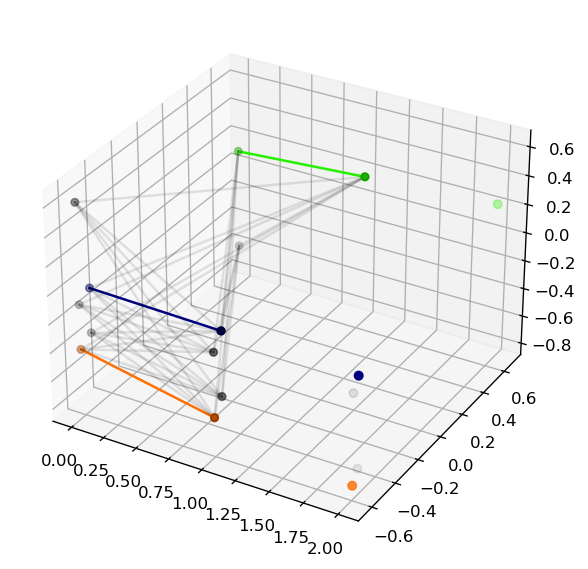

In [166]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import mpl_toolkits.mplot3d.art3d as art3d

def seeds_to_lines(seeds):
    return seeds[['z_p',  'z_c', 'phi_p', 'phi_c','r_p', 'r_c']].values.reshape((-1, 3, 2))

def draw_track(ax, seed, colors_tracks):
    if not seed.track:
        col = (0.0, 0.0, 0.000, 0.1)
    else:
        col = colors_tracks[seed.track_p]

    val_x = seed[['station_p', 'station_c']].values
    val_y = seed[['phi_p', 'phi_c']].values
    val_z = seed[['z_p', 'z_c']].values
    
    ax.plot(val_x, val_y, zs=val_z, color=col)
    ax.scatter(val_x, val_y, zs=val_z, color=col)


def visual_predict(seeds, target, pred):
    
    #for p in pred:
    #    print(p)
    #    return
    
    fig = plt.figure(figsize=(8, 6), dpi=120)
    ax = fig.add_subplot(111, projection='3d')
    
    colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired   
    colors = [colormap(i) for i in np.linspace(0, 1, seeds.track_p.nunique())]
    colors_tracks = { seeds.track_p.unique()[idx]: col for idx, col in enumerate(colors)}
    colors_tracks[-1] = (0.0, 0.0, 0.000, 0.1)
    
    for (idx, seed) in seeds.iterrows():
        draw_track(ax, seed, colors_tracks)    

    target_colors = [colors_tracks[c[0]] for c in target[['track']].values]
    
    ax.scatter(target[['station']].values, target[['phi']].values, zs=target[['z']].values, color=target_colors, s=25)
    
    

visual_predict(seeds, target, pred)

In [146]:
[c[0] for c in target[['track']].values]


[11, 22, 23, -1, -1]

array([11, 22, 23, -1])

In [31]:
events_to_analyze[events_to_analyze.event == 0]

,event,x,y,z,station,track,px,py,pz,X0,Y0,Z0
0,0,-80.90526,-10.27410,-145.16400,0,-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0,-75.78151,-30.13936,-36.07856,0,-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0,-75.78151,-30.13936,259.80060,0,-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0,70.23064,-41.45931,-249.45830,0,-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0,-124.69720,-18.45198,-211.95370,1,-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0,-118.92740,-41.78675,-61.32032,1,-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0,-164.06280,-28.70505,-295.25830,2,-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0,-158.77350,-50.31454,-60.33907,2,-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0,-80.90526,-10.27410,-11.94216,0,11,-0.193425,-0.004823,-0.029994,0.879332,-0.230192,0.127600
9,0,-124.69720,-18.45198,-18.66805,1,11,-0.193425,-0.004823,-0.029994,0.879332,-0.230192,0.127600


In [146]:
import faiss
index = faiss.IndexFlatL2(2)
db = np.ascontiguousarray(target[['z','y']].values).astype('float32')
index.add(db)

what_search = np.ascontiguousarray(target[['z','y']].values[:3].astype('float32'))

dist, idx = index.search(what_search, 3)
print(f"dist = {dist}")
print(f"idx = {idx}")
print(f"db = {db}")
print(f"what_search = {what_search}")

dist = [[  0.       0.     494.9469]
 [  0.       0.     494.9469]
 [  0.       0.     494.9469]]
idx = [[2 0 1]
 [1 4 2]
 [2 0 1]]
db = [[-164.0628   -28.70505]
 [-158.7735   -50.31454]
 [-164.0628   -28.70505]
 [ 144.4699   -82.87949]
 [-158.7735   -50.31454]]
what_search = [[-164.0628   -28.70505]
 [-158.7735   -50.31454]
 [-164.0628   -28.70505]]


In [149]:
import faiss
index = faiss.IndexFlatL2(2)
db = np.ascontiguousarray(target[['x','y']].values).astype('float32')
index.add(db)

what_search = np.ascontiguousarray(target[['x','y']].values[:3].astype('float32')) + 10

dist, idx = index.search(what_search, 3)
print(f"dist = {dist}")
print(f"idx = {idx}")
print(f"db = {db}")
print(f"what_search = {what_search}")

dist = [[ 200.       200.      1021.3506 ]
 [ 200.       200.       368.54318]
 [ 200.       200.      1021.3506 ]]
idx = [[2 0 1]
 [1 4 2]
 [2 0 1]]
db = [[-164.0628   -28.70505]
 [-158.7735   -50.31454]
 [-164.0628   -28.70505]
 [ 144.4699   -82.87949]
 [-158.7735   -50.31454]]
what_search = [[-154.0628   -18.70505]
 [-148.7735   -40.31454]
 [-154.0628   -18.70505]]


In [135]:
target[['x','y']].values[:3]

array([[-164.0628 ,  -28.70505],
       [-158.7735 ,  -50.31454],
       [-164.0628 ,  -28.70505]])

In [124]:
np.ascontiguousarray(target[['x','y']].values[:3].astype('float32'))

array([[-164.0628 ,  -28.70505],
       [-158.7735 ,  -50.31454],
       [-164.0628 ,  -28.70505]], dtype=float32)